In [35]:
import yfinance as yf
import pandas as pd
import os


In [36]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [42]:
sp500.index = pd.to_datetime(sp500.index)

In [49]:
# filter dates to only inlcude after 1990-01-01
filter_date = pd.Timestamp('1990-01-01', tz='UTC').tz_convert('US/Eastern')
sp500 = sp500[sp500.index >= filter_date]


<AxesSubplot:xlabel='Date'>

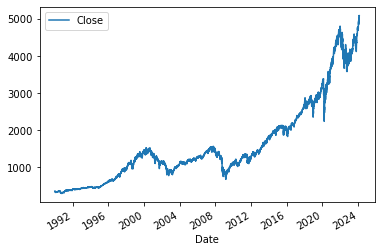

In [52]:
# plot data to see historical closing prices
sp500.plot.line(y="Close", use_index=True)

In [50]:
# delete unwanted columns
del sp500["Dividends"]
del sp500["Stock Splits"]

In [59]:
# create column for tomorrow's price
sp500["Tomorrow"] = sp500["Close"].shift(-1)

# create target, is tomorrow price greater than today's price, creating as integer
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [58]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

# develop training data, last 100 days and test day, first 100 days
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [61]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
# find precisions score, how often did the model predict the market to go up
precision_score(test["Target"], preds)


0.53125

<AxesSubplot:xlabel='Date'>

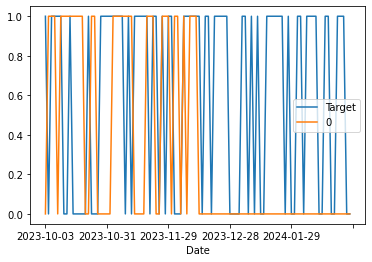

In [62]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

The model (orange) predicted fluctuation, then a downturn. In reality, there was consistent fluctuation over time. This is reflective in the low precision score

In [63]:
# develop function for previous manual steps
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [64]:
# develop function to back test
# back test will start with the first 10 years and predict the next year, then use the previous 11 years to predict the 12th year
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [65]:

predictions = backtest(sp500, model, predictors)
predictions["Predictions"].value_counts()

0    2852
1    2251
Name: Predictions, dtype: int64

The model predicts a downturn on 2852 days of the data and an increase on 2251 days. How does this compare to reality?

In [66]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5388716126166149

In [67]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.544582
0    0.455418
Name: Target, dtype: float64

The model predicts the market will go up at a lower rate than reality. Better off buying and selling every day. Need more features

In [68]:
# develop rolling averages based on specified time periods
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [70]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

,Open,High,Low,Close,Volume,Tomorrow,Target,Clsoe_Ration_2,Trend_2,Clsoe_Ration_5,...,Clsoe_Ration_250,Trend_250,Clsoe_Ration_1000,Trend_1000,Close_Ratio_2,Close_Ratio_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Close_Ratio_1000
Date,,,,,,,,,,,,,,,,,,,,,
1997-11-26,950.820007,956.469971,950.820007,951.640015,487750000,955.400024,1,1.000431,2.0,0.997275,...,1.113282,138.0,1.517046,563.0,1.000431,0.997275,1.009111,33.0,1.113282,1.517046
1997-11-28,951.640015,959.130005,951.640015,955.400024,189070000,974.770020,1,1.001972,2.0,1.001967,...,1.116599,139.0,1.521842,564.0,1.001972,1.001967,1.012659,33.0,1.116599,1.521842
1997-12-01,955.400024,974.770020,955.400024,974.770020,590300000,971.679993,0,1.010035,2.0,1.019783,...,1.138015,140.0,1.551433,564.0,1.010035,1.019783,1.032356,34.0,1.138015,1.551433
1997-12-02,974.780029,976.200012,969.830017,971.679993,576120000,976.770020,1,0.998412,1.0,1.011259,...,1.133204,140.0,1.545272,563.0,0.998412,1.011259,1.028349,33.0,1.133204,1.545272
1997-12-03,971.679993,980.809998,966.159973,976.770020,624610000,973.099976,0,1.002612,1.0,1.011095,...,1.137882,141.0,1.552105,564.0,1.002612,1.011095,1.032949,33.0,1.137882,1.552105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-20,4989.319824,4993.709961,4955.020020,4975.509766,4034880000,4981.799805,1,0.996988,0.0,0.996513,...,1.131010,139.0,1.236084,531.0,0.996988,0.996513,1.041254,37.0,1.131010,1.236084
2024-02-21,4963.029785,4983.209961,4946.000000,4981.799805,3788390000,5087.029785,1,1.000632,1.0,0.996630,...,1.131421,140.0,1.237065,531.0,1.000632,0.996630,1.041027,37.0,1.131421,1.237065
2024-02-22,5038.830078,5094.390137,5038.830078,5087.029785,4051710000,5088.799805,1,1.010451,2.0,1.014175,...,1.154193,140.0,1.262542,532.0,1.010451,1.014175,1.061066,37.0,1.154193,1.262542


In [71]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [73]:
# rewrite predict function
# use prediction probability and customize confidence in prediciton from 50% to 60% to ensure that an increase in price is predicted only
# when model is more sure in probability
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [74]:
predictions = backtest(sp500, model, new_predictors)
predictions["Predictions"].value_counts()


0.0    3542
1.0     561
Name: Predictions, dtype: int64

In [75]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5650623885918004

In [76]:
predictions["Target"].value_counts() / predictions.shape[0]


1    0.541068
0    0.458932
Name: Target, dtype: float64

New precision score is higher than the SP500 overtime. Model has some prediciton value as the SP500 goes up 54% of the time, however, when the model says the price will go up, the price goes up 56% of the time.